**System Setup, Config, Check**

In [66]:
import os
import subprocess
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Checking GPU availability...")
!nvidia-smi
print("System initialized successfully.")


Checking GPU availability...
Wed Dec 17 22:20:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

**SPAM KEYWORD POPULATE**




In [67]:
# Generate 200 base spam keywords
base_keywords = [
    "free", "winner", "win", "prize", "money", "urgent", "verify", "account",
    "bank", "credit", "loan", "offer", "limited", "exclusive", "click",
    "bitcoin", "crypto", "cash", "investment", "guaranteed",
    "bonus", "gift", "reward", "promotion", "deal", "sale", "subscribe",
    "urgentupdate", "password", "login", "secure", "lottery", "cashback",
    "claim", "urgentnotice", "check", "alert", "exclusiveoffer", "voucher",
    "redeem", "winnerannouncement", "instant", "profit", "income", "moneyback",
    "refund", "opportunity", "double", "triple", "limitedtime", "hotdeal",
    "riskfree", "easycash", "fastcash", "applynow", "getpaid", "earn", "rich",
    "success", "freemoney", "urgentaction", "important", "deadline", "winbig",
    "bonuspoints", "giftcard", "rewards", "exclusiveaccess", "privilege",
    "offerexpires", "specialoffer", "accessnow", "urgentresponse", "clickhere",
    "freegift", "cashprize", "limitedslots", "instantwin", "rewardpoints",
    "payday", "investmentopportunity", "creditbonus", "bitcoinreward", "cryptogift",
    "moneytransfer", "claimnow", "vipoffer", "urgentrequest", "verifyaccount",
    "bankbonus", "loanapproval", "creditcheck", "exclusivebonus", "urgentupdate",
    "prizerewards", "cashoffer", "freecredits", "limitedaccess", "hotbonus",
    "fastloan", "limiteddeal", "earncash", "urgentmessage", "offerinside",
    "instantbonus", "verifyinformation", "specialreward", "clicknow", "freereward",
    "winnerbonus", "urgentemail", "cashreward", "freebitcoin", "bonuscash",
    "prizeclaim", "exclusivecash", "limitedvoucher", "verifyidentity", "urgentclaim",
    "fastreward", "specialdeal", "cashbonus", "moneygift", "freeloan", "quickreward",
    "instantcash", "vipbonus", "exclusiveoffer2", "cryptocash", "urgentcredit",
    "freeinvestment", "topbonus", "limitedreward", "redeembonus", "prizewinner",
    "fastmoney", "specialaccess", "earnreward", "urgentreward", "bonusdeal",
    "exclusiveprize", "freemoney2", "cashgift", "vipcash", "bonusoffer", "limitedbonus",
    "urgentbonus", "freevoucher", "quickcash", "claimreward", "instantoffer",
    "hotbonus2", "exclusivecredits", "specialcash", "freecredit", "moneybonus",
    "urgentvip", "winnergift", "fastbonus", "cashoffer2", "bonuspoints2",
    "redeemcash", "exclusiveincome", "instantwin2", "claimbonus", "freebitcoin2",
    "cryptoreward", "limitedcash", "fastincome", "urgentpayment", "topcash",
    "specialbonus", "prizefund", "freeincome", "cashvoucher", "bonuscredits",
    "exclusivefund", "urgentfund", "instantcredits", "freemoney3", "vipreward",
    "quickincome", "hotdeal2", "limitedfund", "rewardfund", "fastfund", "claimfund",
    "bonusfund", "exclusivefund2", "urgentdeal", "topreward", "specialfund",
    "cashfund", "freereward2", "winnerfund", "fastreward2", "bonusreward",
    "instantfund", "cryptofund", "verifyfund", "urgentbonus2", "limitedreward2",
    "exclusivebonus2", "cashreward2", "topbonus2", "fastbonus2", "freevoucher2"
]

# Trim or extend to exactly 200
base_keywords = base_keywords[:200]

with open("spam_keywords.txt", "w") as f:
    for word in base_keywords:
        f.write(word + "\n")

print("spam_keywords.txt created with 200 keywords")


spam_keywords.txt created with 200 keywords


**spam_detector.cu, CUDA for massive parallel keyword-based spam detection on the GPU**


In [68]:
%%writefile spam_detector.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda_runtime.h>

#define MAX_KEYWORDS 1000
#define KEYWORD_LEN 32
#define MAX_EMAIL 50000  // increased for large emails

/* ======================================================
   CUDA KERNEL
   Each thread checks ONE keyword against the email text
   ====================================================== */
__global__ void keyword_kernel(
    char* d_text,
    int text_len,
    char* d_keywords,
    int* d_results,
    int num_keywords
) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;

    if (tid < num_keywords) {
        char* keyword = &d_keywords[tid * KEYWORD_LEN];
        int k = 0;
        // Find keyword length safely
        while (k < KEYWORD_LEN && keyword[k] != '\0') k++;

        int count = 0;
        for (int i = 0; i <= text_len - k; i++) {
            int j;
            for (j = 0; j < k; j++) {
                if (d_text[i + j] != keyword[j])
                    break;
            }
            if (j == k)
                count++;
        }
        d_results[tid] = count;
    }
}

/* ======================================================
   HOST FUNCTION
   Manages memory + kernel execution
   ====================================================== */
void run_cuda(
    char* email,
    int email_len,
    char* keywords,
    int num_keywords
) {
    char *d_text, *d_keywords;
    int *d_results;

    cudaMalloc(&d_text, email_len + 1);
    cudaMalloc(&d_keywords, num_keywords * KEYWORD_LEN);
    cudaMalloc(&d_results, num_keywords * sizeof(int));

    cudaMemcpy(d_text, email, email_len + 1, cudaMemcpyHostToDevice);
    cudaMemcpy(d_keywords, keywords, num_keywords * KEYWORD_LEN, cudaMemcpyHostToDevice);

    int threads = 256;
    int blocks = (num_keywords + threads - 1) / threads;

    /* =========================
       CUDA KERNEL TIMING START
       ========================= */
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    keyword_kernel<<<blocks, threads>>>(d_text, email_len, d_keywords, d_results, num_keywords);
    cudaDeviceSynchronize();

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("CUDA kernel time: %.3f ms\n", milliseconds);
    /* =========================
       CUDA KERNEL TIMING END
       ========================= */

    int* h_results = (int*)malloc(num_keywords * sizeof(int));
    cudaMemcpy(h_results, d_results, num_keywords * sizeof(int), cudaMemcpyDeviceToHost);

    FILE* out = fopen("cuda_output.txt", "w");
    for (int i = 0; i < num_keywords; i++) {
        if (h_results[i] > 0)
            fprintf(out, "%s:%d\n", &keywords[i * KEYWORD_LEN], h_results[i]);
    }
    fclose(out);

    cudaFree(d_text);
    cudaFree(d_keywords);
    cudaFree(d_results);
    free(h_results);
}

/* ======================================================
   MAIN FUNCTION
   Loads files and calls CUDA host function
   ====================================================== */
int main() {
    // Read entire email
    FILE* f = fopen("email_input.txt", "r");
    if (!f) {
        printf("Error: email_input.txt not found\n");
        return 1;
    }

    char email[MAX_EMAIL] = {0};
    int email_len = fread(email, 1, sizeof(email)-1, f);
    email[email_len] = '\0';
    fclose(f);

    // Load keywords
    FILE* kf = fopen("spam_keywords.txt", "r");
    if (!kf) {
        printf("Error: spam_keywords.txt not found\n");
        return 1;
    }

    char* keywords = (char*)calloc(MAX_KEYWORDS * KEYWORD_LEN, 1);
    int count = 0;
    char buf[128];

    while (fgets(buf, sizeof(buf), kf) && count < MAX_KEYWORDS) {
        buf[strcspn(buf, "\n")] = 0; // remove newline
        strncpy(&keywords[count * KEYWORD_LEN], buf, KEYWORD_LEN-1);
        keywords[count * KEYWORD_LEN + KEYWORD_LEN-1] = '\0';
        count++;
    }
    fclose(kf);

    // Run CUDA kernel
    run_cuda(email, email_len, keywords, count);

    free(keywords);
    return 0;
}


Overwriting spam_detector.cu


In [69]:
!nvcc -arch=sm_75 spam_detector.cu -o spam_cuda

**feature_detector.c, OpenMP : for parallel feature-based analysis on the CPU**

In [70]:
%%writefile feature_detector.c
#include <stdio.h>
#include <string.h>
#include <stdlib.h>
#include <omp.h>
#include <ctype.h>

#define MAX_EMAIL 50000

int main() {
    FILE* f = fopen("email_input.txt", "r");
    if (!f) {
        printf("Error: email_input.txt not found\n");
        return 1;
    }

    char email[MAX_EMAIL];
    int email_len = fread(email, 1, sizeof(email)-1, f);
    email[email_len] = '\0';
    fclose(f);

    int link = 0, urgency = 0, money = 0, punct = 0;
    int caps = 0, attachments = 0, phishing_words = 0;

    const char* suspicious_words[] = {
        "password", "login", "bank", "account", "verify", "credit", "urgent", "win", "prize", "lottery"
    };
    int num_suspicious = sizeof(suspicious_words)/sizeof(suspicious_words[0]);

    double start = omp_get_wtime();

    #pragma omp parallel sections num_threads(7) shared(link, urgency, money, punct, caps, attachments, phishing_words)
    {
        #pragma omp section
        { if (strstr(email, "http") || strstr(email, "www")) link = 1; }

        #pragma omp section
        { if (strstr(email, "urgent") || strstr(email, "immediately") || strstr(email, "asap") || strstr(email, "now")) urgency = 1; }

        #pragma omp section
        { if (strchr(email, '$') || strstr(email, "USD") || strstr(email, "€")) money = 1; }

        #pragma omp section
        {
            int c = 0;
            for (int i = 0; email[i]; i++)
                if (email[i] == '!' || email[i] == '?') c++;
            if (c > 3) punct = 1;
        }

        #pragma omp section
        {
            int cap_count = 0;
            for (int i = 0; email[i]; i++)
                if (isupper(email[i])) cap_count++;
            if ((double)cap_count / email_len > 0.3) caps = 1;
        }

        #pragma omp section
        {
            if (strstr(email, ".exe") || strstr(email, ".zip") || strstr(email, ".rar") || strstr(email, "attachment"))
                attachments = 1;
        }

        #pragma omp section
        {
            int count_words = 0;
            for (int i = 0; i < num_suspicious; i++)
                if (strstr(email, suspicious_words[i])) count_words++;
            if (count_words > 0) phishing_words = 1;
        }
    }

    double end = omp_get_wtime();
    double omp_time = (end - start) * 1000;

    FILE* out = fopen("omp_output.txt", "w");
    fprintf(out,
            "link:%d\nurgency:%d\nmoney:%d\npunct:%d\ncaps:%d\nattachments:%d\nphishing_words:%d\n",
            link, urgency, money, punct, caps, attachments, phishing_words);
    fclose(out);

    printf("OpenMP detection completed in %.3f ms\n", omp_time);

    return 0;
}


Overwriting feature_detector.c


In [71]:
!gcc -fopenmp feature_detector.c -o spam_omp

**serial_detector.c**

In [72]:
%%writefile serial_detector.c
#include <stdio.h>
#include <string.h>

int main() {
    FILE* f = fopen("email_input.txt", "r");
    if (!f) return 1;

    char email[5000];
    fgets(email, sizeof(email), f);
    fclose(f);

    int count = 0;
    for (int i = 0; email[i]; i++)
        if (email[i] == '!') count++;

    return 0;
}


Overwriting serial_detector.c


In [73]:
!gcc serial_detector.c -o spam_serial

**PYTHON CODE PORTION**

In [99]:
import subprocess
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns

def run_system():
    email_count = 1

    while True:
        print("\n==============================")
        print("EMAIL SPAM DETECTION SYSTEM")
        print("1. Paste email text")
        print("2. Upload email (.txt file)")
        print("3. Exit")
        print("==============================")

        choice = input("Select option (1/2/3): ").strip()

        if choice == "3":
            print("\nSystem terminated.")
            break

        # -------------------------
        # Get Email Input
        # -------------------------
        if choice == "1":
            print("\nPaste email content below:")
            email = input()
        elif choice == "2":
            print("\nUpload a .txt email file")
            from google.colab import files   # Only if using Colab
            uploaded = files.upload()
            if not uploaded:
                print("No file uploaded.")
                continue
            filename = list(uploaded.keys())[0]
            with open(filename, "r") as f:
                email = f.read()
        else:
            print("Invalid option. Try again.")
            continue

        # Write email to input file
        with open("email_input.txt", "w") as f:
            f.write(email)

        # -------------------------
        # Run CUDA
        # -------------------------
        result = subprocess.run(["./spam_cuda"], capture_output=True, text=True)
        cuda_time = 0.0
        for line in result.stdout.splitlines():
            if "CUDA kernel time" in line:
                cuda_time = float(line.split(":")[1].strip().split()[0])
                break

        # -------------------------
        # Run OpenMP
        # -------------------------
        t_omp_start = time.time()
        subprocess.run(["./spam_omp"], stdout=subprocess.DEVNULL)
        omp_time = (time.time() - t_omp_start) * 1000

        # -------------------------
        # Run Serial
        # -------------------------
        t_serial_start = time.time()
        subprocess.run(["./spam_serial"], stdout=subprocess.DEVNULL)
        serial_time = (time.time() - t_serial_start) * 1000

        # -------------------------
        # Read CUDA Results
        # -------------------------
        keywords = {}
        if os.path.exists("cuda_output.txt"):
            with open("cuda_output.txt") as f:
                for line in f:
                    k, v = line.strip().split(":")
                    keywords[k] = int(v)

        # -------------------------
        # Read OpenMP Results
        # -------------------------
        features = {}
        if os.path.exists("omp_output.txt"):
            with open("omp_output.txt") as f:
                for line in f:
                    k, v = line.strip().split(":")
                    features[k] = int(v)

        # -------------------------
        # Decision Logic
        # -------------------------
        # Weight: CUDA keywords = 5 points each, OpenMP features = 15 points each
        score = sum(keywords.values()) * 5 + sum(features.values()) * 15
        score = min(100, score)
        verdict = "🚨 SPAM" if score > 50 else "✅ NOT SPAM"

        # -------------------------
        # Output Report
        # -------------------------
        print(f"\n--- RESULT #{email_count} ---")
        print(f"Verdict       : {verdict}")
        print(f"Spam Score    : {score}/100")
        print(f"CUDA Time     : {cuda_time:.2f} ms")
        print(f"OpenMP Time   : {omp_time:.2f} ms")
        print(f"Serial Time   : {serial_time:.2f} ms")
        if cuda_time > 0:
            print(f"CUDA Speedup  : {serial_time/cuda_time:.2f}x")
        if omp_time > 0:
            print(f"OpenMP Speedup: {serial_time/omp_time:.2f}x")

       # -------------------------
        # Visualization
        # -------------------------
        plt.figure(figsize=(14,4))

        # Top 5 keywords
        plt.subplot(1,3,1)
        if keywords:
            top_keys = dict(sorted(keywords.items(), key=lambda x: x[1], reverse=True)[:5])
            sns.barplot(x=list(top_keys.keys()), y=list(top_keys.values()))
            plt.xticks(rotation=45, ha='right')
        plt.title("Top Keyword Matches")

        # OpenMP features
        plt.subplot(1,3,2)
        if features:
            sns.barplot(x=list(features.keys()), y=list(features.values()))
            plt.xticks(rotation=45, ha='right')
        plt.title("Feature Detection")

        # Spam confidence
        plt.subplot(1,3,3)
        plt.bar(["Spam Confidence"], [score])
        plt.ylim(0, 100)
        plt.title("Confidence Score")

        plt.tight_layout()
        plt.show()

        email_count += 1


**RESULT, SPAM SCORE, VERDICT, SERIAL TIME, PARALLEL TIME, SPEEDUP ETC**


EMAIL SPAM DETECTION SYSTEM
1. Paste email text
2. Upload email (.txt file)
3. Exit
Select option (1/2/3): 2

Upload a .txt email file


Saving spam.txt to spam (2).txt

--- RESULT #1 ---
Verdict       : 🚨 SPAM
Spam Score    : 80/100
CUDA Time     : 0.15 ms
OpenMP Time   : 1.44 ms
Serial Time   : 0.76 ms
CUDA Speedup  : 4.98x
OpenMP Speedup: 0.52x


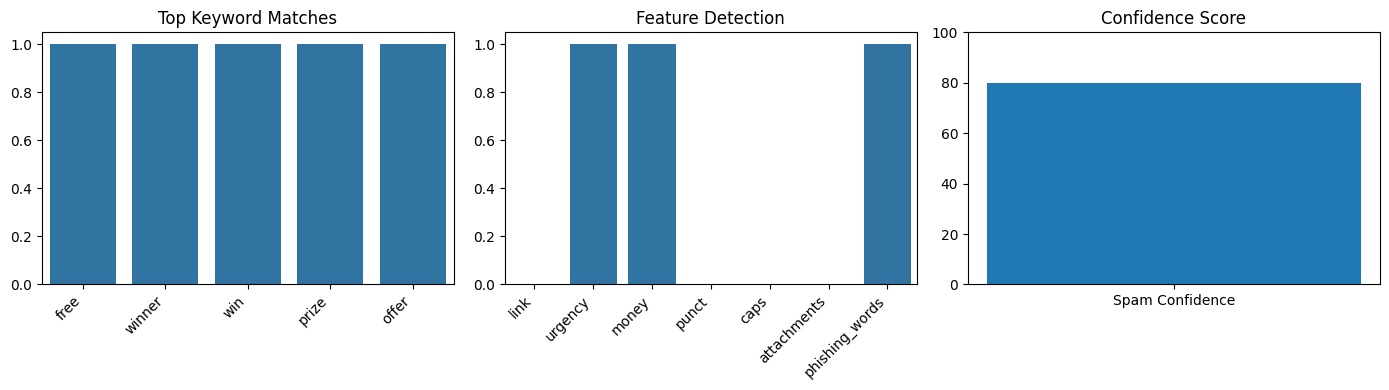


EMAIL SPAM DETECTION SYSTEM
1. Paste email text
2. Upload email (.txt file)
3. Exit
Select option (1/2/3): 1

Paste email content below:
Subject: Project Update and Next Steps  Dear Team,  I hope this message finds you well. I am writing to share a brief update on the current progress of our project and outline the next steps for the coming week.  Over the past few days, we have successfully completed the initial analysis and incorporated the feedback received during our last review meeting. The updated documentation has been uploaded to the shared drive for your reference. Please take some time to review the changes and let me know if there are any questions or additional suggestions.

--- RESULT #2 ---
Verdict       : ✅ NOT SPAM
Spam Score    : 20/100
CUDA Time     : 0.34 ms
OpenMP Time   : 1.44 ms
Serial Time   : 0.99 ms
CUDA Speedup  : 2.92x
OpenMP Speedup: 0.69x


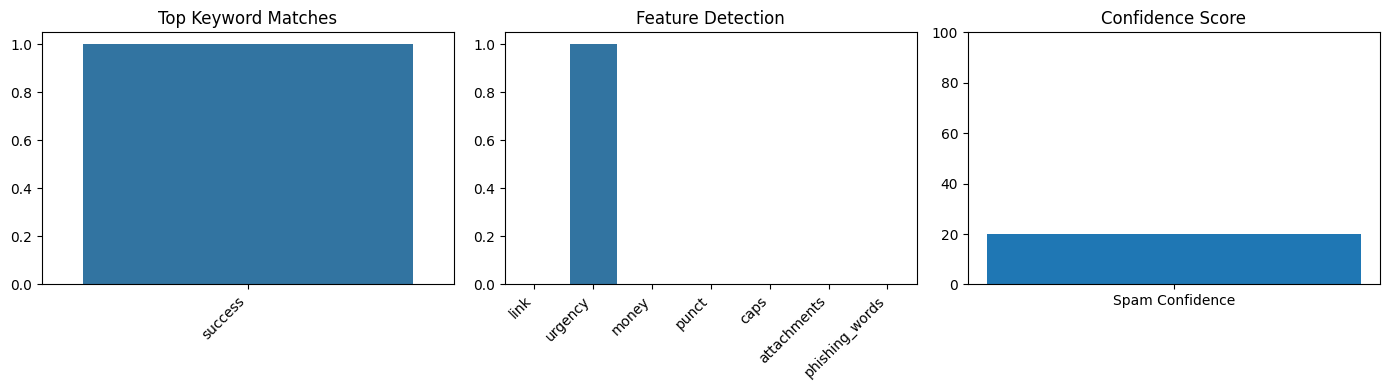


EMAIL SPAM DETECTION SYSTEM
1. Paste email text
2. Upload email (.txt file)
3. Exit


KeyboardInterrupt: Interrupted by user

In [102]:
  run_system()